In [60]:
import pandas as pd
import matplotlib.pyplot as plt

# I want to load a csv placed in ../logs/log_ear_mar.csv
# with this header timestamp;path_img;ear;mar

# And load into a dataframe using pandas

file_path = "../logs/log_ear_mar.csv"

df = pd.read_csv(file_path, sep=";")

In [61]:
df['category'] = df['path_img'].apply(lambda x: x.split('/')[2])
df

# cast ear and mar to float
df['ear'] = df['ear'].astype(float)
df['mar'] = df['mar'].astype(float)

In [62]:
df

,timestamp,path_img,ear,mar,category
0,20230911220029563455,./frames/bostezo/frame_20230911220029563455.jpg,0.140504,0.682872,bostezo
1,20230911220029682586,./frames/bostezo/frame_20230911220029682586.jpg,0.147645,0.800760,bostezo
2,20230911220029743451,./frames/bostezo/frame_20230911220029743451.jpg,0.189989,0.849610,bostezo
3,20230911220029822007,./frames/bostezo/frame_20230911220029822007.jpg,0.132697,0.818756,bostezo
4,20230911220029908184,./frames/bostezo/frame_20230911220029908184.jpg,0.159582,0.852484,bostezo
...,...,...,...,...,...
2288,20230913204142763855,./frames/boca_abierta_ojos_abiertos/frame_2023...,0.210518,0.641856,boca_abierta_ojos_abiertos
2289,20230913204142836976,./frames/boca_abierta_ojos_abiertos/frame_2023...,0.219036,0.618897,boca_abierta_ojos_abiertos
2290,20230913204142935674,./frames/boca_abierta_ojos_abiertos/frame_2023...,0.209302,0.665549,boca_abierta_ojos_abiertos
2291,20230913204143051935,./frames/boca_abierta_ojos_abiertos/frame_2023...,0.225868,0.618897,boca_abierta_ojos_abiertos


In [63]:
# mostrar las distintas categorias
category_list = df['category'].unique()

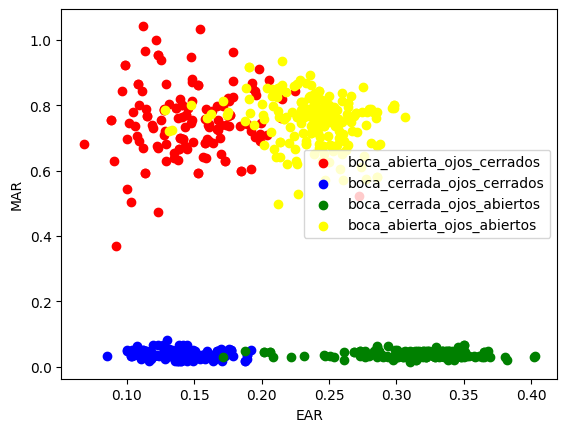

In [64]:
# plot ear vs mar, coloring different categories
colors = {
    'boca_abierta_ojos_cerrados': 'red',
    'boca_cerrada_ojos_cerrados': 'blue',
    'boca_cerrada_ojos_abiertos': 'green',
    'boca_abierta_ojos_abiertos': 'yellow'
}

# Plot a scatter plot with labels per category
for category in colors.keys():
    plt.scatter(df[df['category'] == category]['ear'], df[df['category'] == category]['mar'], c=colors[category], label=category)

plt.xlabel('EAR')
plt.ylabel('MAR')
plt.legend()
plt.show()


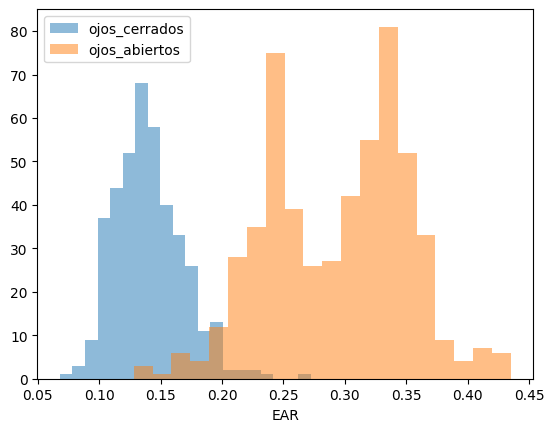

In [65]:
# Create a distribution plot for categories that contains 'ojos_cerrados' vs 'ojos_abiertos' and EAR
plt.hist(df[df['category'].str.contains('ojos_cerrados')]['ear'], bins=20, alpha=0.5, label='ojos_cerrados')
plt.hist(df[df['category'].str.contains('ojos_abiertos')]['ear'], bins=20, alpha=0.5, label='ojos_abiertos')
plt.xlabel('EAR')
plt.legend()
plt.show()

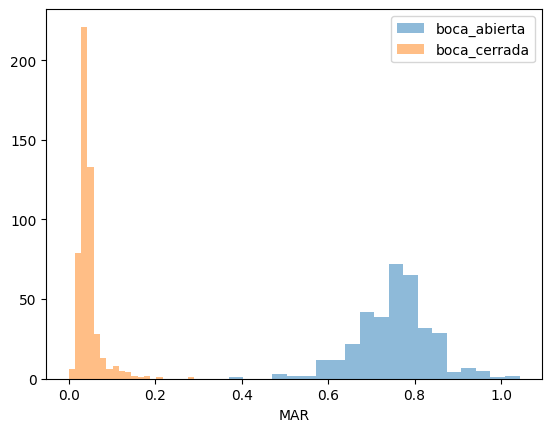

In [66]:
# Create a distribution plot for categories that contains 'boca_abierta' vs 'boca_cerrada' and MAR
plt.hist(df[df['category'].str.contains('boca_abierta')]['mar'], bins=20, alpha=0.5, label='boca_abierta')
plt.hist(df[df['category'].str.contains('boca_cerrada')]['mar'], bins=20, alpha=0.5, label='boca_cerrada')
plt.xlabel('MAR')
plt.legend()
plt.show()

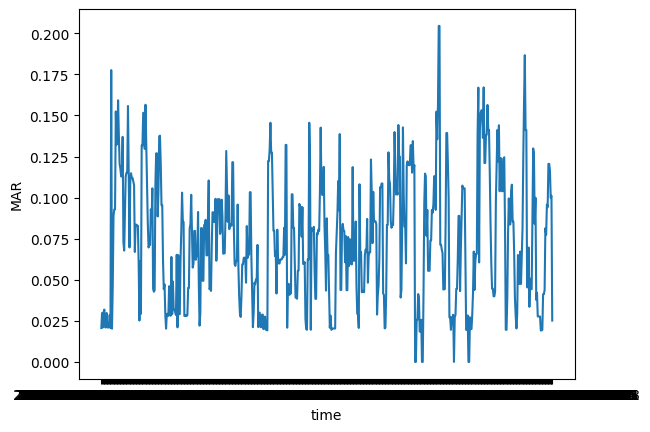

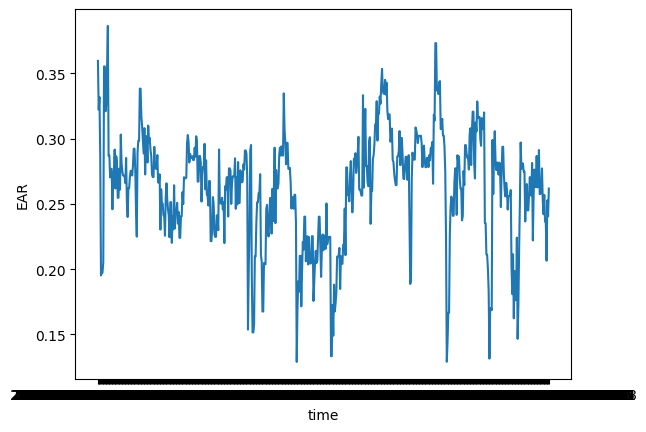

In [67]:
# Plot MAR and EAR vs time for "hablando" category
plt.plot(df[df['category'] == 'hablando']['timestamp'], df[df['category'] == 'hablando']['mar'])
plt.xlabel('time')
plt.ylabel('MAR')
plt.show()

plt.plot(df[df['category'] == 'hablando']['timestamp'], df[df['category'] == 'hablando']['ear'])
plt.xlabel('time')
plt.ylabel('EAR')
plt.show()


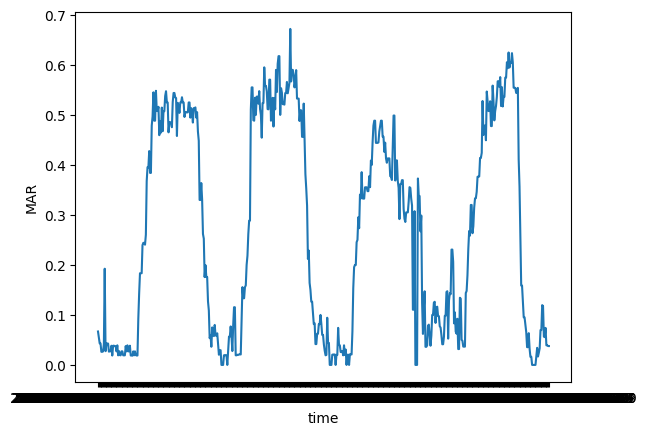

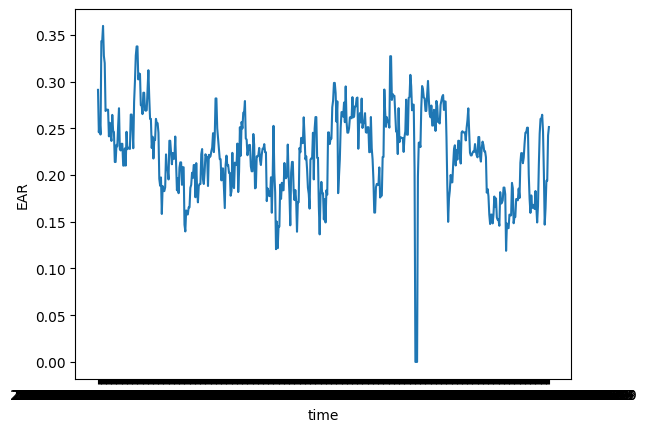

In [68]:
# Plot MAR and EAR vs time for "bostezando" category
plt.plot(df[df['category'] == 'bostezando']['timestamp'], df[df['category'] == 'bostezando']['mar'])
plt.xlabel('time')
plt.ylabel('MAR')
plt.show()

plt.plot(df[df['category'] == 'bostezando']['timestamp'], df[df['category'] == 'bostezando']['ear'])
plt.xlabel('time')
plt.ylabel('EAR')
plt.show()

In [69]:
# Filter only the category like "boca_xxx_ojos_xxx"
df_filtered = df[df['category'].str.contains('boca_') & df['category'].str.contains('_ojos_')]

# Calculate the THRESHOLD for EAR and MAR to optimize the classification
# We will use the mean of the "ojos_cerrados" and "ojos_abiertos" categories
# and the mean of the "boca_abierta" and "boca_cerrada" categories
ear_threshold = (df_filtered[df_filtered['category'].str.contains('ojos_cerrados')]['ear'].mean() + df_filtered[df_filtered['category'].str.contains('ojos_abiertos')]['ear'].mean()) / 2
mar_threshold = (df_filtered[df_filtered['category'].str.contains('boca_abierta')]['mar'].mean() + df_filtered[df_filtered['category'].str.contains('boca_cerrada')]['mar'].mean()) / 2

print("EAR threshold: ", ear_threshold)
print("MAR threshold: ", mar_threshold)

# Contando todo
# EAR threshold:  0.21733906173899536
# MAR threshold:  0.3988620258294028

# Filtrando datos
# EAR threshold:  0.20950204295557165
# MAR threshold:  0.39596885286034145

EAR threshold:  0.20950204295557165
MAR threshold:  0.39596885286034145


In [84]:
# Add columns with threshold values and create a new column with the classification
df['ear_threshold'] = ear_threshold
df['mar_threshold'] = mar_threshold

# one or zero for classification
df['ear_classification'] = (df['ear'] > df['ear_threshold']).astype(int)
df['mar_classification'] = (df['mar'] > df['mar_threshold']).astype(int)

FRAMES = 200

# add columns with min and max values for the past 100 frames of each timestamp
df['ear_min'] = df['ear'].rolling(FRAMES).min()
df['ear_max'] = df['ear'].rolling(FRAMES).max()
df['mar_min'] = df['mar'].rolling(FRAMES).min()
df['mar_max'] = df['mar'].rolling(FRAMES).max()

# add columns with the mean of the past FRAMES seconds of each timestamp
df['ear_mean'] = df['ear'].rolling(FRAMES).mean()
df['mar_mean'] = df['mar'].rolling(FRAMES).mean()

# add columns with the std of the past FRAMES seconds of each timestamp
df['ear_std'] = df['ear'].rolling(FRAMES).std()
df['mar_std'] = df['mar'].rolling(FRAMES).std()

# add columns with the median of the past FRAMES seconds of each timestamp
df['ear_median'] = df['ear'].rolling(FRAMES).median()
df['mar_median'] = df['mar'].rolling(FRAMES).median()

# add columns with the variance of the past FRAMES seconds of each timestamp
df['ear_var'] = df['ear'].rolling(FRAMES).var()
df['mar_var'] = df['mar'].rolling(FRAMES).var()

# add columns with the skew of the past FRAMES seconds of each timestamp
df['ear_skew'] = df['ear'].rolling(FRAMES).skew()
df['mar_skew'] = df['mar'].rolling(FRAMES).skew()

# add columns with the kurt of the past FRAMES seconds of each timestamp
df['ear_kurt'] = df['ear'].rolling(FRAMES).kurt()
df['mar_kurt'] = df['mar'].rolling(FRAMES).kurt()

df

,timestamp,path_img,ear,mar,category,ear_threshold,mar_threshold,ear_classification,mar_classification,ear_min,...,ear_std,mar_std,ear_median,mar_median,ear_var,mar_var,ear_skew,mar_skew,ear_kurt,mar_kurt
0,20230911220029563455,./frames/bostezo/frame_20230911220029563455.jpg,0.140504,0.682872,bostezo,0.209502,0.395969,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,20230911220029682586,./frames/bostezo/frame_20230911220029682586.jpg,0.147645,0.800760,bostezo,0.209502,0.395969,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,20230911220029743451,./frames/bostezo/frame_20230911220029743451.jpg,0.189989,0.849610,bostezo,0.209502,0.395969,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,20230911220029822007,./frames/bostezo/frame_20230911220029822007.jpg,0.132697,0.818756,bostezo,0.209502,0.395969,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,20230911220029908184,./frames/bostezo/frame_20230911220029908184.jpg,0.159582,0.852484,bostezo,0.209502,0.395969,0,1,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,20230913204142763855,./frames/boca_abierta_ojos_abiertos/frame_2023...,0.210518,0.641856,boca_abierta_ojos_abiertos,0.209502,0.395969,1,1,0.128115,...,0.029396,0.072457,0.243201,0.767115,0.000864,0.005250,-1.082884,-0.664684,2.272984,0.932124
2289,20230913204142836976,./frames/boca_abierta_ojos_abiertos/frame_2023...,0.219036,0.618897,boca_abierta_ojos_abiertos,0.209502,0.395969,1,1,0.128115,...,0.029425,0.073103,0.243201,0.767115,0.000866,0.005344,-1.074797,-0.650936,2.244032,0.831059
2290,20230913204142935674,./frames/boca_abierta_ojos_abiertos/frame_2023...,0.209302,0.665549,boca_abierta_ojos_abiertos,0.209502,0.395969,0,1,0.128115,...,0.029490,0.073380,0.243201,0.767115,0.000870,0.005385,-1.062500,-0.634822,2.187940,0.768965
2291,20230913204143051935,./frames/boca_abierta_ojos_abiertos/frame_2023...,0.225868,0.618897,boca_abierta_ojos_abiertos,0.209502,0.395969,1,1,0.128115,...,0.029478,0.073992,0.243201,0.767115,0.000869,0.005475,-1.065662,-0.627470,2.199896,0.683608


In [71]:
category_list

array(['bostezo', 'ojos_cerrados', 'ojos_abiertos', 'boca_cerrada',
       'hablando', 'bostezando', 'boca_abierta_ojos_cerrados',
       'boca_cerrada_ojos_cerrados', 'boca_cerrada_ojos_abiertos',
       'boca_abierta_ojos_abiertos'], dtype=object)

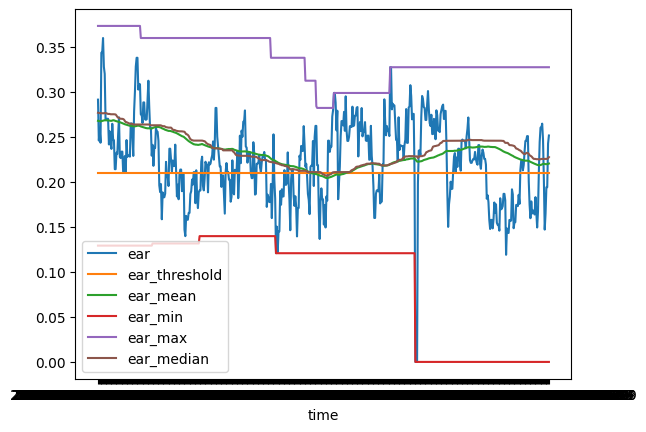

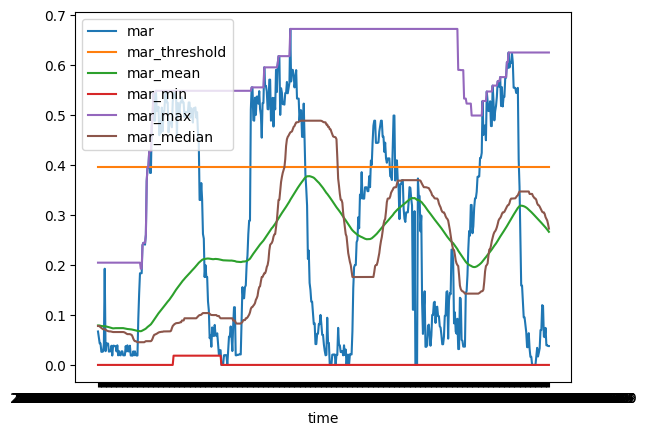

In [85]:
# Plot features vs time for category
category = "bostezando"
plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear'], label='ear')
plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_threshold'], label='ear_threshold')
plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_mean'], label='ear_mean')
plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_min'], label='ear_min')
plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_max'], label='ear_max')
# plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_std'], label='ear_std')
plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_median'], label='ear_median')
# plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_var'], label='ear_var')
# plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_skew'], label='ear_skew')
# plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['ear_kurt'], label='ear_kurt')
plt.xlabel('time')
plt.legend()
plt.show()


plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar'], label='mar')
plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_threshold'], label='mar_threshold')
plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_mean'], label='mar_mean')
plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_min'], label='mar_min')
plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_max'], label='mar_max')
# plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_std'], label='mar_std')
plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_median'], label='mar_median')
# plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_var'], label='mar_var')
# plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_skew'], label='mar_skew')
# plt.plot(df[df['category'] == category]['timestamp'], df[df['category'] == category]['mar_kurt'], label='mar_kurt')
plt.xlabel('time')
plt.legend()
plt.show()
